In [12]:
# code for getting the correspondences between 2d pixels in the image and 3d point in the pointcloud 
import os.path as osp 
import json
import cv2
import open3d as o3d
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

dirpath2 = '/home/aditya/Research/phd/courses/6.4212_RoboticManipulation/6.4212_RoboticManipulation/2flgy/'

image_path1 = osp.join(dirpath2, '1/rgb/00000.jpg')
image_path2 = osp.join(dirpath2, '4/rgb/00000.jpg')

def generate_colored_pcd(depth_path, rgb_path, camera_intrinsic_file, visualize=False):
    instrinsics = read_intrinsics(camera_intrinsic_file)

    # create the camera intrinsics matrix 
    camera_params = [
        instrinsics['intrinsic_matrix'][0], # fx
        instrinsics['intrinsic_matrix'][4], # fy
        instrinsics['intrinsic_matrix'][6], # cx
        instrinsics['intrinsic_matrix'][7] # cy
    ]

    color_image = cv2.cvtColor(cv2.imread(rgb_path), cv2.COLOR_RGB2BGR)
    depth_image = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)
    
    height, width, _ = color_image.shape
    print(height, width)

    # create a pinhole camera model 
    intrinsic = o3d.camera.PinholeCameraIntrinsic(
        width, 
        height,
        camera_params[0],
        camera_params[1],
        camera_params[2],
        camera_params[3],
    )

    color = o3d.geometry.Image(color_image)
    depth = o3d.geometry.Image(depth_image.astype(np.float32) / 0.5)

    # generate the rgbd
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(color, depth, convert_rgb_to_intensity=False)
    # print(rgbd.shape)

    # generate the pcd using rgbd and intrinsic
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic)

    if visualize:
        o3d.visualization.draw_geometries([pcd])

    return pcd

def read_intrinsics(intrinsic_json):
    with open(intrinsic_json, 'r') as f:
        data = json.load(f)

    return data

In [14]:
depth_path1 = osp.join(dirpath2, '1/depth/00000.png')
depth_path2 = osp.join(dirpath2, '4/depth/00000.png')
# print(osp.exists(depth_path1))
intrinsics_file1 = osp.join(dirpath2, '1/camera_intrinsic.json')
intrinsics_file2 = osp.join(dirpath2, '4/camera_intrinsic.json')

pcd1 = generate_colored_pcd(depth_path1, image_path1, intrinsics_file1)
pcd2 = generate_colored_pcd(depth_path2, image_path2, intrinsics_file2)

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.6, origin=[0, 0, 0])

o3d.visualization.draw_geometries([pcd1, mesh_frame])
o3d.visualization.draw_geometries([pcd2, mesh_frame])

480 640
480 640


Using cache found in /home/aditya/.cache/torch/hub/facebookresearch_dino_main
/home/aditya/miniconda3/envs/cu113_torch1102/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


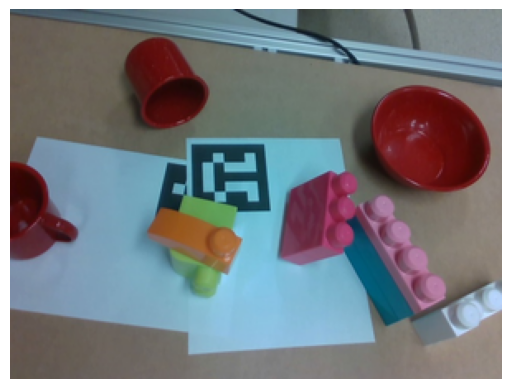

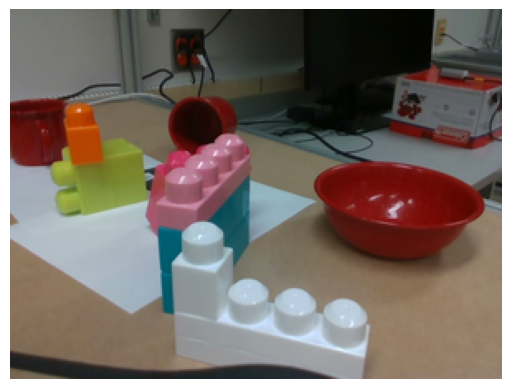

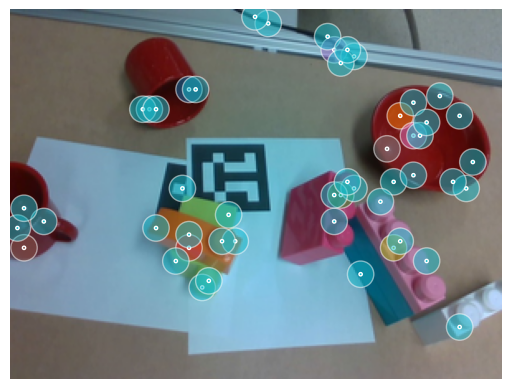

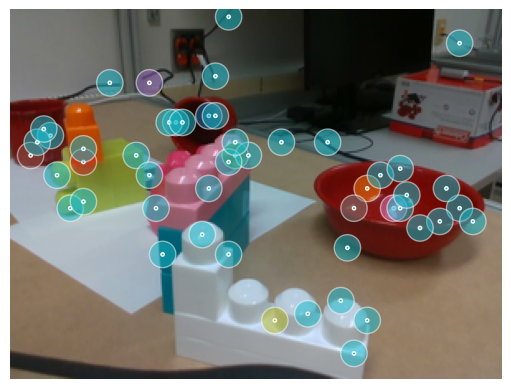

In [36]:
import matplotlib.pyplot as plt
import torch
from correspondences import find_correspondences, draw_correspondences

#@markdown Choose number of points to output:
num_pairs = 50 #@param
#@markdown Choose loading size:
load_size = 224 #@param
#@markdown Choose layer of descriptor:
layer = 9 #@param
#@markdown Choose facet of descriptor:
facet = 'key' #@param
#@markdown Choose if to use a binned descriptor:
bin=True #@param
#@markdown Choose fg / bg threshold:
thresh=0.05 #@param
#@markdown Choose model type:
model_type='dino_vits8' #@param
#@markdown Choose stride:
stride=4 #@param

with torch.no_grad():
    pixel_points1, pixel_points2, image1_pil, image2_pil = find_correspondences(image_path1, image_path2, num_pairs, load_size, layer,
                                                                   facet, bin, thresh, model_type, stride)
fig_1, ax1 = plt.subplots()
ax1.axis('off')
ax1.imshow(image1_pil)
fig_2, ax2 = plt.subplots()
ax2.axis('off')
ax2.imshow(image2_pil)


fig1, fig2 = draw_correspondences(pixel_points1, pixel_points2, image1_pil, image2_pil)
plt.show()

In [78]:
o3d.visualization.draw_geometries([pcd1])
o3d.visualization.draw_geometries([pcd2])

In [16]:
# ts generating the pointcloud using pinholecameraintrinsic -- create_from_rgbd_image 
# mark a certain pixel in the image 
def highlight_image(image_path, points):
    # points is a list here 
    image = mpimg.imread(image_path)
    print(image.shape)
    if not isinstance(points, list):
        points = [points]
    plt.imshow(image)
    for point in points:
        plt.plot(point[1], point[0], 'og', markersize=10)
    plt.show()

# try to generate the same pixel position on the image and corresponding point in pointcloud
# def highlight_points(pcd, pcd_indices, visualize=False):
#     # o3d.visualization.draw_geometries([pcd])

#     pcd_points = np.asarray(pcd.points)
#     num_points = 50
#     pcds = [pcd]
#     # get the point values corresponding to the pcd index 
#     for i, pcd_index in enumerate(pcd_indices):
#         print(pcd_index)
#         points_cluster = np.random.normal((pcd_points[pcd_index]), 1e-2, (num_points, 3))
#         # colors = np.asarray([[np.random.randint(0, 255)/255, np.random.randint(0, 255)/255, np.random.randint(0, 255)/255]]).repeat(num_points, axis=0)
#         colors = np.asarray([[0, 0, 0]]).repeat(num_points, axis=0)

#         pcd_points_cluster = o3d.geometry.PointCloud()
#         pcd_points_cluster.points = o3d.utility.Vector3dVector(points_cluster)
#         pcd_points_cluster.colors = o3d.utility.Vector3dVector(colors)

#         # o3d.visualization.draw_geometries([pcd, pcd_points_cluster])
#         # assert False
#         pcds.append(pcd_points_cluster)

#     if visualize:
#         o3d.visualization.draw_geometries(pcds)

#     return pcds

def highlight_points(pcd, pcd_indices, visualize=False):
    # o3d.visualization.draw_geometries([pcd])

    pcd_points = np.asarray(pcd.points)
    num_points = 50
    pcds = [pcd]
    # get the point values corresponding to the pcd index 
    for i, pcd_index in enumerate(pcd_indices):
        print(pcd_index)
        points_cluster = np.random.normal((pcd_points[pcd_index]), 1e-3, (num_points, 3))
        # colors = np.asarray([[np.random.randint(0, 255)/255, np.random.randint(0, 255)/255, np.random.randint(0, 255)/255]]).repeat(num_points, axis=0)
        colors = np.asarray([[0, 0, 0]]).repeat(num_points, axis=0)

        pcd_points_cluster = o3d.geometry.PointCloud()
        pcd_points_cluster.points = o3d.utility.Vector3dVector(points_cluster)
        pcd_points_cluster.colors = o3d.utility.Vector3dVector(colors)

        # o3d.visualization.draw_geometries([pcd, pcd_points_cluster])
        # assert False
        pcds.append(pcd_points_cluster)

    if visualize:
        o3d.visualization.draw_geometries(pcds)

    return pcds

# read the depth image and check its dimensions 
image = mpimg.imread(depth_path1)
# print(image.shape)

(480, 640, 3)


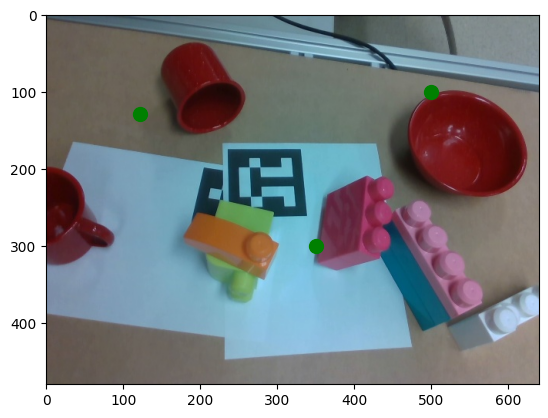

82042
192350
64500


In [18]:
points = [[128, 122], [300, 350], [100, 500]]
# compute the corresponding pcd_indices for the pixel points 
image1 = mpimg.imread(image_path1)
height, width, _ = image1.shape
pcd_indices = list()
for point in points:
    pcd_indices.append(point[0]*width + point[1])

highlight_image(image_path1, points)
pcd_highlighted = highlight_points(pcd1, pcd_indices)
o3d.visualization.draw_geometries(pcd_highlighted)

In [67]:
depth_path = depth_path1
image_path = image_path1 
import numpy as np

def get_intrinsics():
    instrinsics = read_intrinsics(intrinsics_file1)
    fx = instrinsics['intrinsic_matrix'][0]
    fy = instrinsics['intrinsic_matrix'][4]
    cx = instrinsics['intrinsic_matrix'][6]
    cy = instrinsics['intrinsic_matrix'][7]

    return cx, cy, fx, fy


def project_depth_to_pC(depth_pixel):
    """
    project depth pixels to points in camera frame
    using pinhole camera model
    Input:
        depth_pixels: numpy array of (nx3) or (3,)
    Output:
        pC: 3D point in camera frame, numpy array of (nx3)
    """
    # switch u,v due to python convention
    v = depth_pixel[:, 0]
    u = depth_pixel[:, 1]
    Z = depth_pixel[:, 2]
    cx, cy, fx, fy = get_intrinsics()
    X = (u - cx) * Z / fx
    Y = (v - cy) * Z / fy
    pC = np.c_[X, Y, Z]
    return pC


def get_pointcloud(depth_path, image_path):
    # color_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    color_image = mpimg.imread(image_path)
    depth_image = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)

    height, width, _ = color_image.shape
    color_points = list()
    
    for j in range(height):
        for i in range(width):
            color_points.append(color_image[j][i]/255.0)

    print(np.min(color_points))
    print(np.max(color_points))

    u_range = np.arange(depth_image.shape[0])
    v_range = np.arange(depth_image.shape[1])
    depth_v, depth_u = np.meshgrid(v_range, u_range)
    depth_pnts = np.dstack([depth_u, depth_v, depth_image])
    # color_pnts = np.dstack([depth_u, depth_v, color_image])
    depth_pnts = depth_pnts.reshape(
        [depth_pnts.shape[0] * depth_pnts.shape[1], 3]
    )
    # color_pnts = color_pnts.reshape(
    #     [color_pnts.shape[0] * color_pnts.shape[1], 3]
    # )
    pC = project_depth_to_pC(depth_pnts)
    # pC_filter = pC[pC[:, 2] > 0]
    
    print(f'The number of points in the pc are : {pC.shape}') # this has all the points -- this would impact the ordering 
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pC)
    pcd.colors = o3d.utility.Vector3dVector(color_points)

    return pcd

pcd = get_pointcloud(depth_path1, image_path1)
# o3d.visualization.draw_geometries([pcd])
o3d.visualization.draw_geometries([pcd])

0.0
1.0
The number of points in the pc are : (307200, 3)


In [56]:
image = np.asarray(mpimg.imread(image_path1))
print(image.shape)
image = image.reshape(-1, 3)
print(image.shape)

(480, 640, 3)
(307200, 3)


In [22]:
points1 = np.asarray(pcd1.points)
print(points1.shape)

print(480*640) # which means that a lot of the points are removed -- because it should correspond to almost the same number of points 

(287027, 3)
307200


Using cache found in /home/aditya/.cache/torch/hub/facebookresearch_dino_main
/home/aditya/miniconda3/envs/cu113_torch1102/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


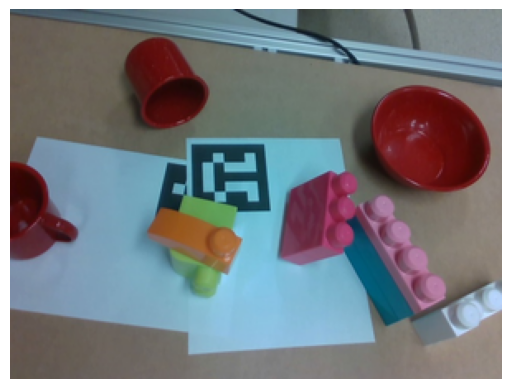

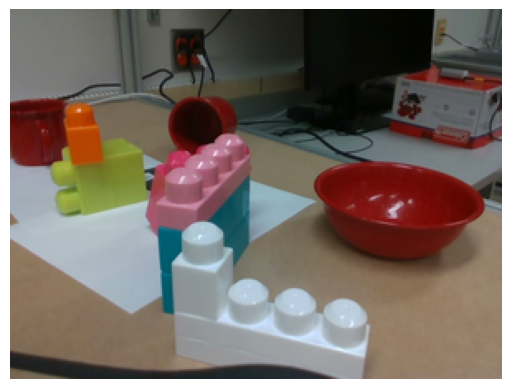

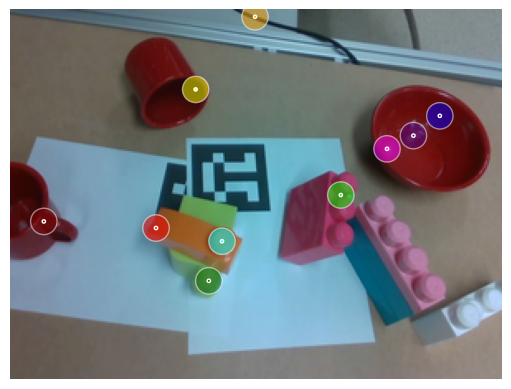

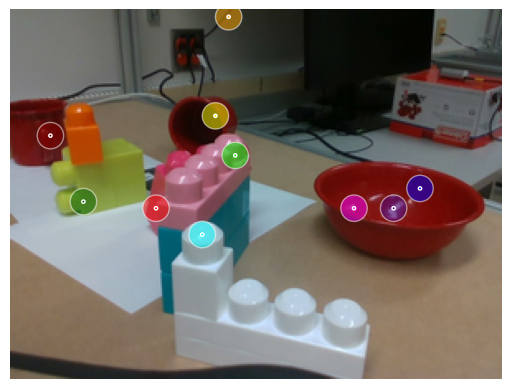

In [9]:
#@markdown Choose number of points to output:
num_pairs = 10 #@param
#@markdown Choose loading size:
load_size = 224 #@param
#@markdown Choose layer of descriptor:
layer = 9 #@param
#@markdown Choose facet of descriptor:
facet = 'key' #@param
#@markdown Choose if to use a binned descriptor:
bin=True #@param
#@markdown Choose fg / bg threshold:
thresh=0.05 #@param
#@markdown Choose model type:
model_type='dino_vits8' #@param
#@markdown Choose stride:
stride=4 #@param

import torch
from correspondences import find_correspondences, draw_correspondences

with torch.no_grad():
    pixel_points1, pixel_points2, image1_pil, image2_pil = find_correspondences(image_path1, image_path2, num_pairs, load_size, layer,
                                                                   facet, bin, thresh, model_type, stride)
fig_1, ax1 = plt.subplots()
ax1.axis('off')
ax1.imshow(image1_pil)
fig_2, ax2 = plt.subplots()
ax2.axis('off')
ax2.imshow(image2_pil)


fig1, fig2 = draw_correspondences(pixel_points1, pixel_points2, image1_pil, image2_pil)
plt.show()

In [26]:
# the next things that's required is to perform ICP between two pointclouds given correspondences 
# write the point indices for correspondences 

# given pixel values as input, get the corresponding point indices from the pointcloud 
def get_point_indices(image, pcd, pixel_points):
    height, width, _ = image.shape 
    pcd_indices = list()
    pcd_values = list()

    pcd_points = np.asarray(pcd.points)
    # print(pcd_points.shape)
    
    for pixel_point in pixel_points:
        pcd_index = pixel_point[0] * width + pixel_point[1]
        # print(pcd_index)
        pcd_indices.append(pcd_index)
        pcd_values.append(pcd_points[pcd_index,:])
    
    return pcd_indices, pcd_values

pcd1 = get_pointcloud(depth_path1, image_path1)

color_image1 = mpimg.imread(image_path1)
pcd_indices1 = get_point_indices(color_image1, pcd1, pixel_points1)

# color_image2 = mpimg.imread(image_path2)
# pcd_indices2 = get_point_indices(color_image2, pcd2, pixel_points2)

0.0
1.0
The number of points in the pc are : (307200, 3)


In [49]:
# filter the pointclouds based on some depth values 
# o3d.visualization.draw_geometries([pcd1])
# o3d.visualization.draw_geometries([pcd2])
import open3d_plus as o3dp

# remove the outliers from the data
pcpoints = np.asarray(pcd2.points )
print(pcpoints.shape)

reconstruction_config = {
    'x_min': -10,
    'x_max': 0.8,
    'y_min' : -10,
    'y_max' : 10,
    'z_min': -10,
    'z_max' : 2
}

def crop_pcd(pcd, reconstruction_config):
    # reconstruction_config = reconstruction_config['pcd_crop_config']
    points, colors = o3dp.pcd2array(pcd)
    mask = points[:, 2] > reconstruction_config['z_min']
    mask = mask & (points[:, 2] < reconstruction_config['z_max'])
    mask = mask & (points[:, 0] > reconstruction_config['x_min'])
    mask = mask & (points[:, 0] < reconstruction_config['x_max'])
    mask = mask & (points[:, 1] < reconstruction_config['y_max'])
    mask = mask & (points[:, 1] > reconstruction_config['y_min'])
    pcd = o3dp.array2pcd(points[mask], colors[mask])

    return pcd

pcdcropped = crop_pcd(pcd2, reconstruction_config)
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.6, origin=[0, 0, 0])
# o3d.visualization.draw_geometries([pcdcropped, mesh_frame])

# generate the icp between this and the other pointcloud 
# first downsample the pcd before performing the pcd 
o3d.visualization.draw_geometries([pcd1, mesh_frame])

# align the two pointclouds using the icp algorithm 

registered_pcd.estimate_normals()
transformations = dict() # transformation matrices representing poses
transformations[camera_order[0]] = np.eye(4, dtype=np.float32)

# TODO: Add progress tracker
for _, camera_pose in enumerate(camera_order[1:]):
    current_pcd = pcds[camera_pose]
    current_pcd.estimate_normals() 
    # register using the point2plane estimation method
    reg_p2p = o3d.pipelines.registration.registration_icp(
        current_pcd, registered_pcd, max_correspondence_distance=0.05,
        estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPlane())

    # transform the current_pcd by the estimated transformation
    current_pcd = current_pcd.transform(reg_p2p.transformation)
    transformations[camera_pose] = np.asarray(reg_p2p.transformation, dtype=np.float32)
    # merge the pcds to get the registered pcd for the current step
    registered_pcd = o3dp.merge_pcds([current_pcd, registered_pcd])
    registered_pcd.estimate_normals()
    if debug_visualization: # visualize the registered pcd at the current step if debug_visualization is set to True
        o3d.visualization.draw_geometries([registered_pcd])


(307200, 3)


NameError: name 'registered_pcd' is not defined

In [163]:
source = pcd1
target = pcd2

from copy import deepcopy

target.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

threshold = 0.02
trans_init = np.asarray([[0.862, 0.011, -0.507, 0.5],
                         [-0.139, 0.967, -0.215, 0.7],
                         [0.487, 0.255, 0.835, -1.4], [0.0, 0.0, 0.0, 1.0]])
print("Apply point-to-plane ICP")
reg_p2l = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPlane())
print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
# draw_registration_result(source, target, reg_p2l.transformation)

source_transformed = deepcopy(source).transform(reg_p2l.transformation)
o3d.visualization.draw_geometries([source_transformed, target])
o3d.visualization.draw_geometries([source, target])

Apply point-to-plane ICP
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
Transformation is:
[[ 0.862  0.011 -0.507  0.5  ]
 [-0.139  0.967 -0.215  0.7  ]
 [ 0.487  0.255  0.835 -1.4  ]
 [ 0.     0.     0.     1.   ]]


In [155]:
import open3d as o3d
import numpy as np

# Create source and target point clouds
source_points = np.random.rand(100, 3)
target_points = source_points + 0.1 * np.random.randn(100, 3)

source_cloud = o3d.geometry.PointCloud()
source_cloud.points = o3d.utility.Vector3dVector(source_points)

target_cloud = o3d.geometry.PointCloud()
target_cloud.points = o3d.utility.Vector3dVector(target_points)

# o3d.visualization.draw_geometries([source_cloud])

# Create normals for the target point cloud (required for Point-to-Plane ICP)
target_cloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# o3d.visualization.draw_geometries([target_cloud])

trans_init = np.asarray([[0.862, 0.011, -0.507, 0.5],
                         [-0.139, 0.967, -0.215, 0.7],
                         [0.487, 0.255, 0.835, -1.4], [0.0, 0.0, 0.0, 1.0]])

# Perform Point-to-Plane ICP
criteria = o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1e-6, relative_rmse=1e-6, max_iteration=50)

print(f'type of source cloud : {type(source_cloud)}')

# transformation_icp = o3d.pipelines.registration.registration_icp(
#     source_cloud, target_cloud, max_correspondence_distance=0.05,
#     criteria=criteria, method=o3d.pipelines.registration.TransformationEstimationPointToPlane()
# )

transformation_icp = o3d.pipelines.registration.registration_icp(
    source_cloud, target_cloud, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPlane())

# Apply the transformation to the source point cloud
source_cloud_icp = source_cloud.transform(transformation_icp.transformation)

# Visualize the original and aligned point clouds
o3d.visualization.draw_geometries([source_cloud, target_cloud, source_cloud_icp])

type of source cloud : <class 'open3d.cuda.pybind.geometry.PointCloud'>


In [124]:
import numpy as np

##Based on Arun et al., 1987

#Writing points with rows as the coordinates
# p1_t = np.array([[0,0,0], [1,0,0],[0,1,0]])
# p2_t = np.array([[0,0,1], [1,0,1],[0,0,2]]) #Approx transformation is 90 degree rot over x-axis and +1 in Z axis

p1_t = np.asarray(pcd_values1)
p2_t = np.asarray(pcd_values2)

#Take transpose as columns should be the points
p1 = p1_t.transpose()
p2 = p2_t.transpose()

#Calculate centroids
p1_c = np.mean(p1, axis = 1).reshape((-1,1)) #If you don't put reshape then the outcome is 1D with no rows/colums and is interpeted as rowvector in next minus operation, while it should be a column vector
p2_c = np.mean(p2, axis = 1).reshape((-1,1))

#Subtract centroids
q1 = p1-p1_c
q2 = p2-p2_c

#Calculate covariance matrix
H=np.matmul(q1,q2.transpose())

#Calculate singular value decomposition (SVD)
U, X, V_t = np.linalg.svd(H) #the SVD of linalg gives you Vt

#Calculate rotation matrix
R = np.matmul(V_t.transpose(),U.transpose())

# assert np.allclose(np.linalg.det(R), 1.0), "Rotation matrix of N-point registration not 1, see paper Arun et al."

#Calculate translation matrix
T = p2_c - np.matmul(R,p1_c)

#Check result
result = T + np.matmul(R,p1)
if np.allclose(result,p2):
    print("transformation is correct!")
else:
    print("transformation is wrong...")

transformation is wrong...


In [140]:
TT = np.eye(4)
TT[:3, :3] = R
TT[:-1, -1:0] = T

import copy

# o3d.visualization.draw_geometries([pcd1.rotate(R).translate(T), pcd2])
pcd2_rotated = copy.deepcopy(pcd2).rotate(R).translate(T)
pcd1_rotated = copy.deepcopy(pcd1).rotate(R).translate(T)

o3d.visualization.draw_geometries([pcd1_rotated, pcd2])
o3d.visualization.draw_geometries([pcd1, pcd2_rotated])
o3d.visualization.draw_geometries([pcd1, pcd2])

480 640
(480, 640, 3)


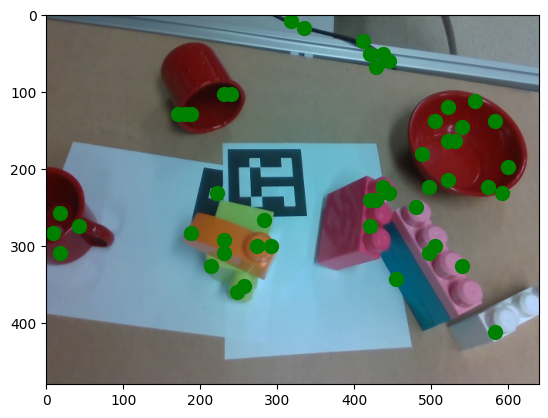

(480, 640, 3)


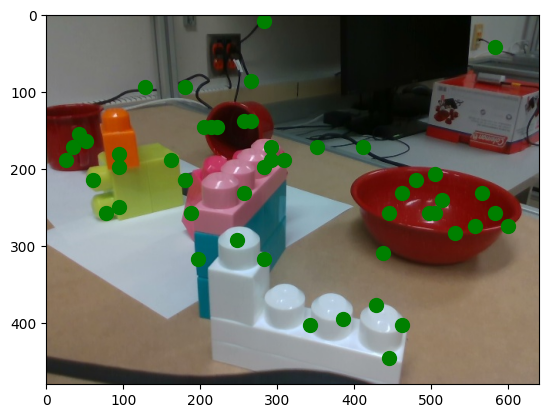

0.0
1.0
The number of points in the pc are : (307200, 3)
0.0
1.0
The number of points in the pc are : (307200, 3)
[66151, 88185, 154028, 197991, 33060, 197777, 104842, 115688, 198257, 181308, 170522, 77322, 209180, 82100, 192291, 230648, 219974, 11214, 148285, 143217, 154020, 148062, 126680, 159840, 264262, 175402, 38845, 104851, 22171, 192505, 192274, 66160, 187111, 43948, 148431, 175780, 181128, 143157, 208854, 82091, 71597, 33077, 88262, 5437, 225537, 143294, 164497, 137482, 82108, 93980]
66151
88185
154028
197991
33060
197777
104842
115688
198257
181308
170522
77322
209180
82100
192291
230648
219974
11214
148285
143217
154020
148062
126680
159840
264262
175402
38845
104851
22171
192505
192274
66160
187111
43948
148431
175780
181128
143157
208854
82091
71597
33077
88262
5437
225537
143294
164497
137482
82108
93980
87937
148302
120611
126174
60340
120345
164977
164925
258262
164668
120482
137440
258382
93654
203162
164557
203077
27462
120628
198197
126362
137140
165062
241708
285885


In [37]:
color_image1 = mpimg.imread(image_path1)
color_image2 = mpimg.imread(image_path2)

height, width, _ = color_image1.shape
print(height, width)
resized_height, resized_width = 224, 298
sample = 1
pixel_points1_scaled = [(int(point[0]*width/resized_width), int(point[1]*height/resized_height)) for point in pixel_points1]
pixel_points2_scaled = [(int(point[0]*width/resized_width), int(point[1]*height/resized_height)) for point in pixel_points2]

highlight_image(image_path1, pixel_points1_scaled)
highlight_image(image_path2, pixel_points2_scaled)
pcd1 = get_pointcloud(depth_path1, image_path1)
pcd2 = get_pointcloud(depth_path2, image_path2)

pcd_indices1, pcd_values1 = get_point_indices(color_image1, pcd1, pixel_points1_scaled)
pcd_indices2, pcd_values2 = get_point_indices(color_image2, pcd2, pixel_points2_scaled)

print(pcd_indices1)

# try to generate the same pixel position on the image and corresponding point in pointcloud
pcd1_highlighted = highlight_points(pcd1, pcd_indices1)
o3d.visualization.draw_geometries(pcd1_highlighted)

pcd2_highlighted = highlight_points(pcd2, pcd_indices2)
o3d.visualization.draw_geometries(pcd2_highlighted)

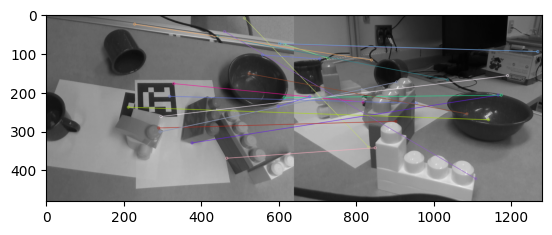

(<matplotlib.image.AxesImage at 0x7f1aaf0f2340>, None)

In [3]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

# ift = cv2.SIFT_create()
# kp = sift.detect(gimg,None)
# img=cv2.drawKeypoints(gimg,kp,img)
# plt.imshow(img)

# read images
img1 = cv2.imread(image_path1)  
img2 = cv2.imread(image_path2) 

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.SIFT_create() 
# kp1, des1 = sift.detectAndCompute(img1, None)

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:20], img2, flags=2)
plt.imshow(img3),plt.show()

In [70]:
# o3d.visualization.draw_geometries([pcd1])
# o3d.visualization.draw_geometries([pcd2])
from copy import deepcopy

pcd2_cropped = crop_pcd(pcd2, reconstruction_config)
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.6, origin=[0, 0, 0])

o3d.visualization.draw_geometries([pcd1, mesh_frame])
o3d.visualization.draw_geometries([pcd2_cropped, mesh_frame])

pcd1.estimate_normals()
pcd2_cropped.estimate_normals() 

# register using the point2plane estimation method
transformation = o3d.pipelines.registration.registration_icp(
    pcd2_cropped, pcd1, max_correspondence_distance=0.05,
    estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPlane())

# apply transformation on pcd1 
pcd2_transformed = deepcopy(pcd2_cropped).transform(transformation.transformation)
o3d.visualization.draw_geometries([pcd1, pcd2_transformed])

In [38]:
import numpy as np

##Based on Arun et al., 1987

#Writing points with rows as the coordinates
# p1_t = np.array([[0,0,0], [1,0,0],[0,1,0]])
# p2_t = np.array([[0,0,1], [1,0,1],[0,0,2]]) #Approx transformation is 90 degree rot over x-axis and +1 in Z axis
p1_t = np.array(pcd_values1)
p2_t = np.array(pcd_values2)
print(p1_t.shape)

#Take transpose as columns should be the points
p1 = p1_t.transpose()
p2 = p2_t.transpose()

#Calculate centroids
p1_c = np.mean(p1, axis = 1).reshape((-1,1)) #If you don't put reshape then the outcome is 1D with no rows/colums and is interpeted as rowvector in next minus operation, while it should be a column vector
p2_c = np.mean(p2, axis = 1).reshape((-1,1))

#Subtract centroids
q1 = p1-p1_c
q2 = p2-p2_c

#Calculate covariance matrix
H=np.matmul(q1,q2.transpose())

#Calculate singular value decomposition (SVD)
U, X, V_t = np.linalg.svd(H) #the SVD of linalg gives you Vt

#Calculate rotation matrix
R = np.matmul(V_t.transpose(),U.transpose())

assert np.allclose(np.linalg.det(R), 1.0), "Rotation matrix of N-point registration not 1, see paper Arun et al."

#Calculate translation matrix
T = p2_c - np.matmul(R,p1_c)

#Check result
result = T + np.matmul(R,p1)
if np.allclose(result,p2):
    print("transformation is correct!")
else:
    print("transformation is wrong...")

(50, 3)
transformation is wrong...


In [46]:
print(R, T)
from copy import deepcopy

pcd1 = get_pointcloud(depth_path1, image_path1)
pcd2 = get_pointcloud(depth_path2, image_path2)

o3d.visualization.draw_geometries([pcd1, pcd2])

pcd1_rotated = deepcopy(pcd1).rotate(R).translate(T)
o3d.visualization.draw_geometries([pcd1_rotated, pcd2])

transformation = np.eye(4)
transformation[:3, :3] = R
transformation[:3, -1] = T.reshape(-1)

print(transformation)

[[ 0.90144286 -0.32165516 -0.28972182]
 [ 0.41030519  0.84822426  0.33491083]
 [ 0.13802328 -0.42077734  0.89660248]] [[ 0.09903879]
 [-0.24092447]
 [-0.01053027]]
0.0
1.0
The number of points in the pc are : (307200, 3)
0.0
1.0
The number of points in the pc are : (307200, 3)
[[ 0.90144286 -0.32165516 -0.28972182  0.09903879]
 [ 0.41030519  0.84822426  0.33491083 -0.24092447]
 [ 0.13802328 -0.42077734  0.89660248 -0.01053027]
 [ 0.          0.          0.          1.        ]]


In [69]:
# register using the point2plane estimation method
pcd1 = get_pointcloud(depth_path1, image_path1)
pcd2 = get_pointcloud(depth_path2, image_path2)

pcd1.estimate_normals()
pcd2_cropped = crop_pcd(pcd2, reconstruction_config)
pcd2_cropped.estimate_normals()
pcd2.estimate_normals()
t_icp = o3d.pipelines.registration.registration_icp(
    pcd2_cropped, pcd1, init=transformation, max_correspondence_distance=0.05,
    estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPlane())

pcd2_rotated = deepcopy(pcd2_cropped).transform(t_icp.transformation)

o3d.visualization.draw_geometries([pcd1, pcd2_rotated])

0.0
1.0
The number of points in the pc are : (307200, 3)
0.0
1.0
The number of points in the pc are : (307200, 3)


In [ ]:
####### 